# 🔄 Part 3: Transfer Learning from CIFAR-10
## Pre-training on CIFAR-10 → Fine-tuning on Waste Dataset

---

### 🎯 מה זה Transfer Learning?
**רעיון:** לומדים על בעיה אחת, מעבירים ידע לבעיה אחרת!
- **שלב 1:** אימון מודל על CIFAR-10 (10 קטגוריות: מטוסים, מכוניות, ציפורים...)
- **שלב 2:** העברת המשקלים (הידע!) למודל לפסולת
- **שלב 3:** Fine-tuning רק על שכבות FC - התאמה למשימה שלנו!

### 💡 למה CIFAR-10?
- **Dataset מפורסם** - 60,000 תמונות 32×32
- **10 קטגוריות** - מטוס, מכונית, ציפור, חתול, צבי, כלב, צפרדע, סוס, ספינה, משאית
- **⚠️ לא רלוונטי לפסולת** - אין בקבוקים/קופסאות/זכוכית!
- **מטרה לימודית** - להבין שTransfer מdataset לא רלוונטי = תוצאות בינוניות

### 📊 תוצאות צפויות:
- 🎯 Val Accuracy: **70-75%** (שיפור קטן מ-02)
- ⚡ אימון מהיר יותר (conv layers כבר "יודעים" features בסיסיים)
- 🤔 למה לא יותר? כי CIFAR-10 לא רלוונטי לפסולת!

### 🆚 השוואה:
- **נוטבוק 02** (from scratch): 69.75%
- **נוטבוק 04** (CIFAR-10 transfer): ~70-75%
- **נוטבוק 05** (ImageNet transfer): צפוי 85-90%! 🚀

## 📦 Import Libraries

In [11]:
import sys
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
src_path = project_root / 'src'
sys.path.insert(0, str(src_path))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt
import json
import time
from datetime import datetime

# Import project modules
import config

print("✅ All libraries imported successfully!")
print(f"📦 PyTorch version: {torch.__version__}")
print(f"🖥️  Device: {config.DEVICE}")

✅ All libraries imported successfully!
📦 PyTorch version: 2.9.1+cpu
🖥️  Device: cpu


## 🏗️ Define SimpleCNN Architecture
### Same as notebook 02 - for fair comparison!

In [12]:
class SimpleCNN(nn.Module):
    """Simple CNN for Transfer Learning experiments."""
    
    def __init__(self, num_classes=10):
        """
        Args:
            num_classes: Number of output classes (10 for CIFAR-10, 4 for waste)
        """
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers (will be pre-trained on CIFAR-10)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        # Calculate flatten size dynamically
        self.flatten_size = 64 * 12 * 12  # After 3 pooling: 96->48->24->12
        
        # Fully Connected Layers (will be replaced for transfer learning)
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.dropout1 = nn.Dropout(0.6)
        
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Conv Block 1
        x = self.pool(self.relu(self.conv1(x)))
        
        # Conv Block 2
        x = self.pool(self.relu(self.conv2(x)))
        
        # Conv Block 3
        x = self.pool(self.relu(self.conv3(x)))
        
        # Flatten
        x = x.view(-1, self.flatten_size)
        
        # FC layers
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

print("✅ SimpleCNN architecture defined!")

✅ SimpleCNN architecture defined!


## 📊 Step 1: Load CIFAR-10 Dataset

In [14]:
# CIFAR-10 transforms (32x32 images → resize to 96x96 for faster training)
cifar_transform = transforms.Compose([
    transforms.Resize(96),  # Smaller size for speed! (96 instead of 224)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                        std=[0.229, 0.224, 0.225])
])

# Download and load CIFAR-10
print("📥 Downloading CIFAR-10 dataset...")
cifar_train = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=cifar_transform
)

cifar_test = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=cifar_transform
)

# Use subset for faster training (10,000 samples instead of 50,000)
import torch.utils.data as data
cifar_train_subset = data.Subset(cifar_train, range(10000))  # 20% of data
cifar_test_subset = data.Subset(cifar_test, range(2000))     # 20% of test

# Create DataLoaders with NUM_WORKERS=0 (faster on Windows!)
cifar_train_loader = DataLoader(
    cifar_train_subset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=0  # 0 is faster on Windows!
)

cifar_test_loader = DataLoader(
    cifar_test_subset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0  # 0 is faster on Windows!
)

# CIFAR-10 class names
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck']

print(f"\n✅ CIFAR-10 loaded successfully!")
print(f"📊 Training samples: {len(cifar_train_subset):,} (subset for speed)")
print(f"📊 Test samples: {len(cifar_test_subset):,}")
print(f"🏷️  Classes: {cifar_classes}")
print(f"⚡ Optimizations: 96x96 resolution, subset data, NUM_WORKERS=0")

📥 Downloading CIFAR-10 dataset...

✅ CIFAR-10 loaded successfully!
📊 Training samples: 10,000 (subset for speed)
📊 Test samples: 2,000
🏷️  Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
⚡ Optimizations: 96x96 resolution, subset data, NUM_WORKERS=0


## 🔍 Visualize CIFAR-10 Samples

C:\Users\Administrator\AppData\Local\Temp\ipykernel_31036\1493476409.py:22: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


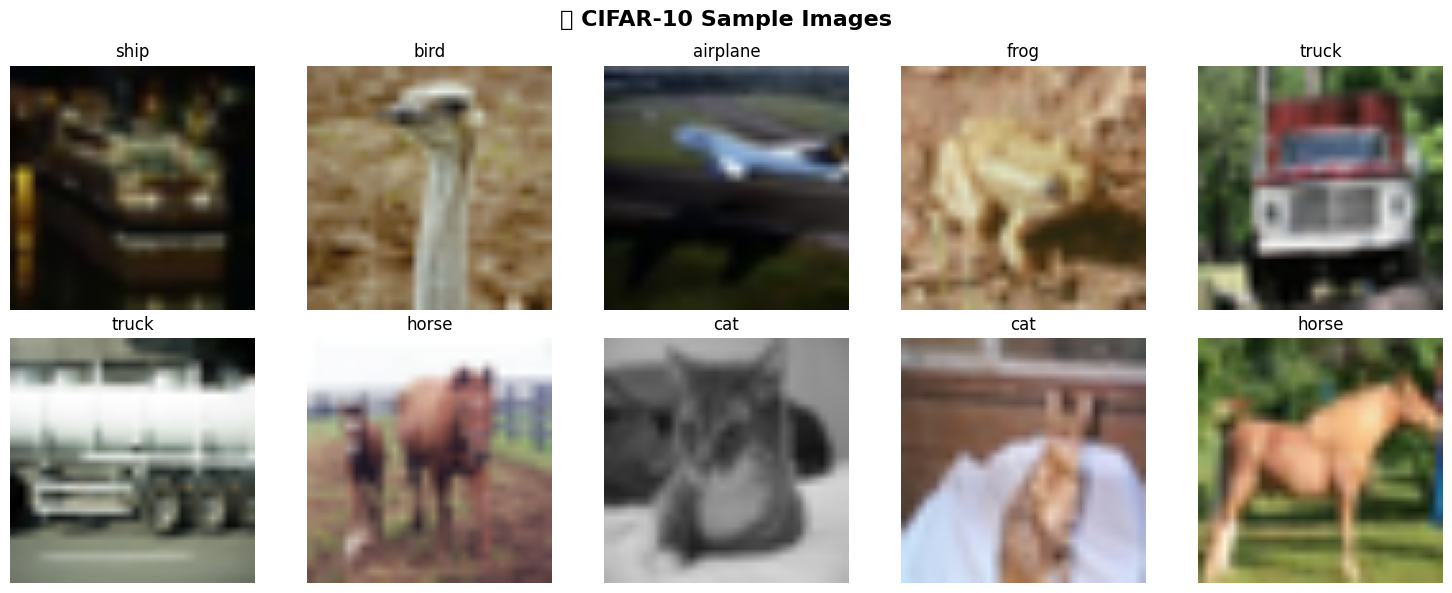

⚠️ Notice: No bottles/cans/waste in CIFAR-10!
This is why transfer from CIFAR-10 won't be as effective as ImageNet.


In [15]:
# Get a batch of images
images, labels = next(iter(cifar_train_loader))

# Denormalize for visualization
def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean

# Plot samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(f"{cifar_classes[labels[i]]}")
    axes[i].axis('off')

plt.suptitle('🖼️ CIFAR-10 Sample Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("⚠️ Notice: No bottles/cans/waste in CIFAR-10!")
print("This is why transfer from CIFAR-10 won't be as effective as ImageNet.")

## 🎓 Step 2: Train Model on CIFAR-10 (Pre-training)
### This is the "knowledge" we'll transfer!

In [16]:
# Create model for CIFAR-10 (10 classes)
model_cifar = SimpleCNN(num_classes=10).to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model_cifar.parameters())
trainable_params = sum(p.numel() for p in model_cifar.parameters() if p.requires_grad)

print("✅ SimpleCNN created for CIFAR-10!")
print(f"📊 Total parameters: {total_params:,}")
print(f"🎯 Trainable parameters: {trainable_params:,}")
print(f"🏷️  Output classes: 10 (CIFAR-10)")

✅ SimpleCNN created for CIFAR-10!
📊 Total parameters: 2,417,322
🎯 Trainable parameters: 2,417,322
🏷️  Output classes: 10 (CIFAR-10)


In [17]:
# Setup training
criterion_cifar = nn.CrossEntropyLoss()
optimizer_cifar = optim.Adam(
    model_cifar.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=1e-4
)

scheduler_cifar = optim.lr_scheduler.StepLR(
    optimizer_cifar,
    step_size=10,
    gamma=0.5
)

print("✅ Optimizer and Scheduler ready!")
print(f"📈 Optimizer: Adam (lr={config.LEARNING_RATE})")
print(f"📉 Scheduler: StepLR (step_size=10, gamma=0.5)")

✅ Optimizer and Scheduler ready!
📈 Optimizer: Adam (lr=0.001)
📉 Scheduler: StepLR (step_size=10, gamma=0.5)


In [18]:
# Training function
def train_epoch_cifar(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(config.DEVICE), labels.to(config.DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

def test_epoch_cifar(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(config.DEVICE), labels.to(config.DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

print("✅ Training functions defined!")

✅ Training functions defined!


In [19]:
# Train on CIFAR-10 (pre-training phase)
print("🚀 Starting CIFAR-10 pre-training...\n")
print("⚡ Optimized for speed: 3 epochs, 96x96 images, 10K samples")
print("⏰ Expected time: ~6-9 minutes\n")

num_epochs_pretrain = 3  # 3 epochs sufficient for basic feature learning
best_test_acc = 0
history_cifar = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

start_time = time.time()

for epoch in range(num_epochs_pretrain):
    # Train
    train_loss, train_acc = train_epoch_cifar(model_cifar, cifar_train_loader, 
                                               criterion_cifar, optimizer_cifar)
    
    # Test
    test_loss, test_acc = test_epoch_cifar(model_cifar, cifar_test_loader, criterion_cifar)
    
    # Update scheduler
    scheduler_cifar.step()
    
    # Save history
    history_cifar['train_loss'].append(train_loss)
    history_cifar['train_acc'].append(train_acc)
    history_cifar['test_loss'].append(test_loss)
    history_cifar['test_acc'].append(test_acc)
    
    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model_cifar.state_dict(), 
                  config.MODELS_DIR / 'cifar10_pretrained.pth')
    
    print(f"Epoch {epoch+1:2d}/{num_epochs_pretrain} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

elapsed_time = time.time() - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"\n✅ CIFAR-10 pre-training completed!")
print(f"⏱️  Training time: {minutes}m {seconds}s")
print(f"🏆 Best test accuracy: {best_test_acc:.2f}%")
print(f"💾 Model saved: cifar10_pretrained.pth")

🚀 Starting CIFAR-10 pre-training...

⚡ Optimized for speed: 3 epochs, 96x96 images, 10K samples
⏰ Expected time: ~6-9 minutes

Epoch  1/3 | Train Loss: 2.0001 | Train Acc: 25.09% | Test Loss: 1.6740 | Test Acc: 40.20%
Epoch  2/3 | Train Loss: 1.6619 | Train Acc: 38.24% | Test Loss: 1.4625 | Test Acc: 46.60%
Epoch  3/3 | Train Loss: 1.5454 | Train Acc: 42.82% | Test Loss: 1.3764 | Test Acc: 49.65%

✅ CIFAR-10 pre-training completed!
⏱️  Training time: 3m 6s
🏆 Best test accuracy: 49.65%
💾 Model saved: cifar10_pretrained.pth


## 📈 Visualize CIFAR-10 Training

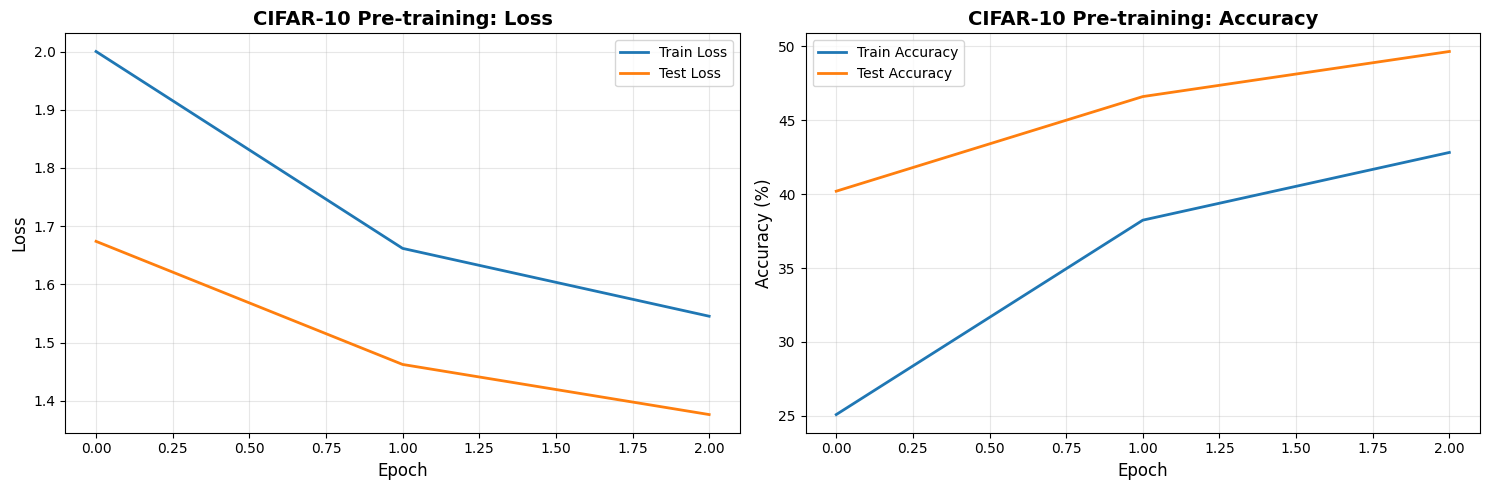

✅ Training curves saved!


In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history_cifar['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history_cifar['test_loss'], label='Test Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('CIFAR-10 Pre-training: Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history_cifar['train_acc'], label='Train Accuracy', linewidth=2)
ax2.plot(history_cifar['test_acc'], label='Test Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('CIFAR-10 Pre-training: Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.PLOTS_DIR / 'cifar10_pretraining.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training curves saved!")

## 🔄 Step 3: Transfer Learning to Waste Dataset
### Load pre-trained weights and fine-tune on our waste data!

In [32]:
# Load our waste dataset
print("📦 Loading waste classification dataset...")

# Create transforms for waste dataset (match CIFAR-10 size: 96x96)
train_transform = transforms.Compose([
    transforms.Resize(96),  # Match CIFAR-10 resolution
    transforms.CenterCrop(96),  # Ensure exactly 96x96!
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop(96),  # Ensure exactly 96x96!
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets (same as notebook 02)
data_path = config.DATA_PATH

# Create full datasets
train_dataset_full = datasets.ImageFolder(root=str(data_path), transform=train_transform)
val_dataset_full = datasets.ImageFolder(root=str(data_path), transform=test_transform)
test_dataset_full = datasets.ImageFolder(root=str(data_path), transform=test_transform)

# Create train/val/test splits (70/15/15)
num_samples = len(train_dataset_full)
indices = list(range(num_samples))
np.random.seed(42)
np.random.shuffle(indices)

train_size = int(config.TRAIN_SPLIT * num_samples)
val_size = int(config.VAL_SPLIT * num_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

from torch.utils.data import Subset
train_dataset = Subset(train_dataset_full, train_indices)
val_dataset = Subset(val_dataset_full, val_indices)
test_dataset = Subset(test_dataset_full, test_indices)

# Create dataloaders with NUM_WORKERS=0
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, 
                         shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, 
                       shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, 
                        shuffle=False, num_workers=0)

print("\n✅ Waste dataset loaded!")
print(f"📊 Training batches: {len(train_loader)}")
print(f"📊 Validation batches: {len(val_loader)}")
print(f"📊 Test batches: {len(test_loader)}")

📦 Loading waste classification dataset...

✅ Waste dataset loaded!
📊 Training batches: 46
📊 Validation batches: 10
📊 Test batches: 10


In [22]:
# Create new model for waste classification (4 classes)
model_transfer = SimpleCNN(num_classes=4).to(config.DEVICE)

# Load CIFAR-10 pre-trained weights (except final FC layer)
print("🔄 Loading CIFAR-10 pre-trained weights...")
pretrained_dict = torch.load(config.MODELS_DIR / 'cifar10_pretrained.pth', 
                             map_location=config.DEVICE)

# Remove final FC layer (fc3) from pretrained weights
pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'fc3' not in k}

# Load partial weights
model_dict = model_transfer.state_dict()
model_dict.update(pretrained_dict)
model_transfer.load_state_dict(model_dict)

print("✅ Pre-trained weights loaded!")
print("📊 Transferred layers: conv1, conv2, conv3, fc1, fc2")
print("🆕 Random init: fc3 (output layer for 4 classes)")

🔄 Loading CIFAR-10 pre-trained weights...
✅ Pre-trained weights loaded!
📊 Transferred layers: conv1, conv2, conv3, fc1, fc2
🆕 Random init: fc3 (output layer for 4 classes)


In [23]:
# Freeze convolutional layers (optional - try both!)
FREEZE_CONV_LAYERS = True  # Set to False to fine-tune all layers

if FREEZE_CONV_LAYERS:
    print("❄️ Freezing convolutional layers...")
    for name, param in model_transfer.named_parameters():
        if 'conv' in name:
            param.requires_grad = False
    print("✅ Conv layers frozen! Only FC layers will be trained.")
else:
    print("🔥 All layers unfrozen! Full fine-tuning.")

# Count trainable parameters
total_params = sum(p.numel() for p in model_transfer.parameters())
trainable_params = sum(p.numel() for p in model_transfer.parameters() if p.requires_grad)

print(f"\n📊 Total parameters: {total_params:,}")
print(f"🎯 Trainable parameters: {trainable_params:,}")
print(f"❄️ Frozen parameters: {total_params - trainable_params:,}")

❄️ Freezing convolutional layers...
✅ Conv layers frozen! Only FC layers will be trained.

📊 Total parameters: 2,416,548
🎯 Trainable parameters: 2,392,964
❄️ Frozen parameters: 23,584


In [24]:
# Setup for fine-tuning
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_transfer.parameters()),  # Only trainable params
    lr=0.0001,  # Lower learning rate for fine-tuning!
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=10,
    gamma=0.5
)

print("✅ Fine-tuning setup ready!")
print(f"📈 Optimizer: Adam (lr=0.0001 - lower for fine-tuning!)")
print(f"📉 Scheduler: StepLR (step_size=10, gamma=0.5)")

✅ Fine-tuning setup ready!
📈 Optimizer: Adam (lr=0.0001 - lower for fine-tuning!)
📉 Scheduler: StepLR (step_size=10, gamma=0.5)


## 🎯 Step 4: Fine-tune on Waste Dataset

In [25]:
# Training and validation functions (same as notebook 02)
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(config.DEVICE)
        labels = labels.to(config.DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(config.DEVICE)
            labels = labels.to(config.DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("✅ Training functions ready!")

✅ Training functions ready!


In [33]:
# Fine-tuning loop
print("🚀 Starting fine-tuning on waste dataset...\n")

best_val_acc = 0
best_epoch = 0
patience_counter = 0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

start_time = time.time()

for epoch in range(config.NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(model_transfer, train_loader, criterion, optimizer)
    
    # Validate
    val_loss, val_acc = validate_epoch(model_transfer, val_loader, criterion)
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Check for improvement
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
        # Save best model
        torch.save(model_transfer.state_dict(), 
                  config.MODELS_DIR / 'transfer_cifar10_best.pth')
        status = "💾 [SAVED]"
    else:
        patience_counter += 1
        status = f"⏳ [{patience_counter}/{config.PATIENCE}]"
    
    # Print progress
    print(f"Epoch {epoch+1:2d}/{config.NUM_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | {status}")
    
    # Early stopping
    if patience_counter >= config.PATIENCE:
        print(f"\n⚠️ Early stopping triggered! No improvement for {config.PATIENCE} epochs.")
        break

elapsed_time = time.time() - start_time
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"\n{'='*70}")
print(f"✅ Fine-tuning completed!")
print(f"⏱️  Training time: {minutes}m {seconds}s")
print(f"🏆 Best validation accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
print(f"💾 Best model saved as: transfer_cifar10_best.pth")
print(f"{'='*70}")

🚀 Starting fine-tuning on waste dataset...

Epoch  1/25 | Train Loss: 1.4203 | Train Acc: 29.95% | Val Loss: 1.3487 | Val Acc: 32.17% | 💾 [SAVED]
Epoch  2/25 | Train Loss: 1.3604 | Train Acc: 33.77% | Val Loss: 1.3042 | Val Acc: 38.22% | 💾 [SAVED]
Epoch  3/25 | Train Loss: 1.3165 | Train Acc: 37.86% | Val Loss: 1.2662 | Val Acc: 41.40% | 💾 [SAVED]
Epoch  4/25 | Train Loss: 1.2860 | Train Acc: 39.97% | Val Loss: 1.2350 | Val Acc: 42.36% | 💾 [SAVED]
Epoch  5/25 | Train Loss: 1.2755 | Train Acc: 42.16% | Val Loss: 1.2103 | Val Acc: 44.90% | 💾 [SAVED]
Epoch  6/25 | Train Loss: 1.2315 | Train Acc: 45.43% | Val Loss: 1.1902 | Val Acc: 47.13% | 💾 [SAVED]
Epoch  7/25 | Train Loss: 1.2025 | Train Acc: 46.86% | Val Loss: 1.1691 | Val Acc: 47.45% | 💾 [SAVED]
Epoch  8/25 | Train Loss: 1.1584 | Train Acc: 49.05% | Val Loss: 1.1517 | Val Acc: 49.36% | 💾 [SAVED]
Epoch  9/25 | Train Loss: 1.1695 | Train Acc: 47.20% | Val Loss: 1.1353 | Val Acc: 50.64% | 💾 [SAVED]
Epoch 10/25 | Train Loss: 1.1452 | Tra

## 📊 Visualize Fine-tuning Results

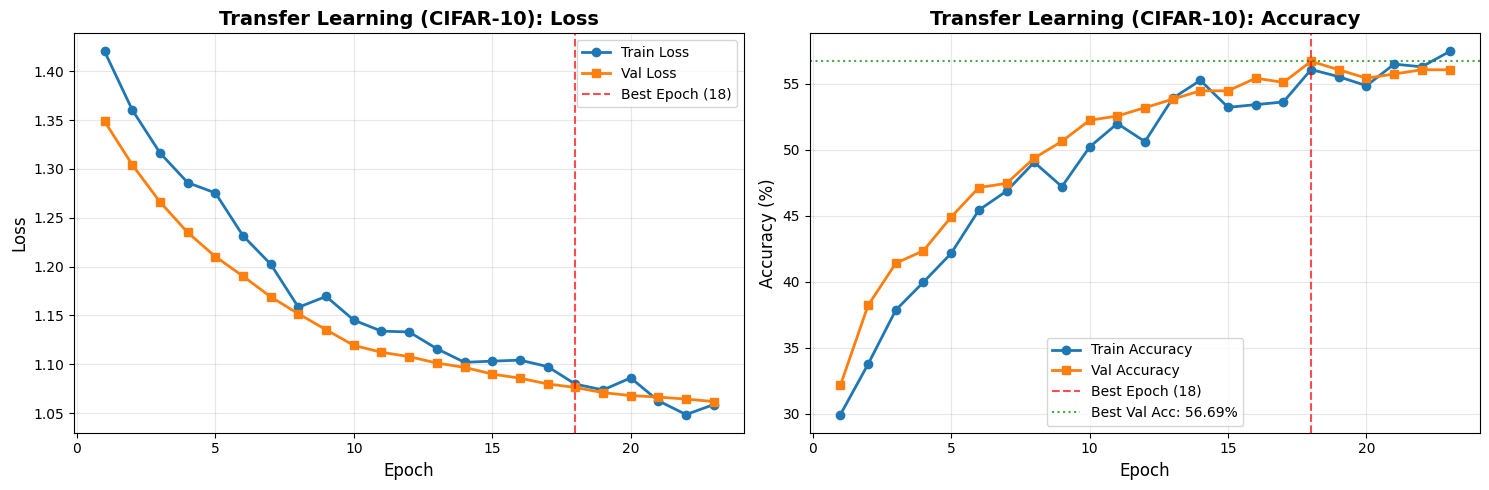

✅ Fine-tuning curves saved!


In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss plot
ax1.plot(epochs_range, history['train_loss'], 'o-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 's-', label='Val Loss', linewidth=2)
ax1.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Transfer Learning (CIFAR-10): Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs_range, history['train_acc'], 'o-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs_range, history['val_acc'], 's-', label='Val Accuracy', linewidth=2)
ax2.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax2.axhline(y=best_val_acc, color='green', linestyle=':', alpha=0.7, label=f'Best Val Acc: {best_val_acc:.2f}%')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Transfer Learning (CIFAR-10): Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.PLOTS_DIR / 'transfer_cifar10_finetuning.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Fine-tuning curves saved!")

## 🧪 Step 5: Evaluate on Test Set

In [35]:
# Load best model
model_transfer.load_state_dict(torch.load(config.MODELS_DIR / 'transfer_cifar10_best.pth'))

# Evaluate on test set
test_loss, test_acc = validate_epoch(model_transfer, test_loader, criterion)

print("\n" + "="*70)
print("🧪 TEST SET EVALUATION")
print("="*70)
print(f"📊 Test Loss: {test_loss:.4f}")
print(f"🎯 Test Accuracy: {test_acc:.2f}%")
print("="*70)

# Calculate overfitting gap
overfitting_gap = history['train_acc'][-1] - best_val_acc
print(f"\n📈 Final Training Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"📊 Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"🎯 Test Accuracy: {test_acc:.2f}%")
print(f"⚖️  Overfitting Gap: {overfitting_gap:.2f}%")


🧪 TEST SET EVALUATION
📊 Test Loss: 1.0258
🎯 Test Accuracy: 60.63%

📈 Final Training Accuracy: 57.44%
📊 Best Validation Accuracy: 56.69%
🎯 Test Accuracy: 60.63%
⚖️  Overfitting Gap: 0.75%


## 📝 Save Results

In [36]:
# Save comprehensive results
results = {
    'model_name': 'SimpleCNN_Transfer_CIFAR10',
    'transfer_learning': {
        'source_dataset': 'CIFAR-10',
        'target_dataset': 'Waste Classification',
        'frozen_layers': 'conv1, conv2, conv3' if FREEZE_CONV_LAYERS else 'None',
        'trainable_layers': 'fc1, fc2, fc3' if FREEZE_CONV_LAYERS else 'All'
    },
    'pretraining': {
        'epochs': num_epochs_pretrain,
        'best_cifar10_acc': best_test_acc,
        'dataset_size': len(cifar_train_subset),
        'optimizations': 'Subset (10K), 96x96 resolution, NUM_WORKERS=0'
    },
    'finetuning': {
        'final_epoch': len(history['train_loss']),
        'best_epoch': best_epoch,
        'train_acc': float(history['train_acc'][-1]),
        'val_acc': float(best_val_acc),
        'test_acc': float(test_acc),
        'train_loss': float(history['train_loss'][-1]),
        'val_loss': float(min(history['val_loss'])),
        'test_loss': float(test_loss),
        'overfitting_gap': float(overfitting_gap),
        'training_time_minutes': minutes + seconds/60
    },
    'hyperparameters': {
        'batch_size': config.BATCH_SIZE,
        'learning_rate': 0.0001,
        'weight_decay': 1e-4,
        'optimizer': 'Adam',
        'scheduler': 'StepLR',
        'scheduler_params': {'step_size': 10, 'gamma': 0.5},
        'dropout_rates': [0.6, 0.5],
        'early_stopping_patience': config.PATIENCE
    },
    'history': {
        'train_loss': [float(x) for x in history['train_loss']],
        'train_acc': [float(x) for x in history['train_acc']],
        'val_loss': [float(x) for x in history['val_loss']],
        'val_acc': [float(x) for x in history['val_acc']]
    },
    'experiment_notes': {
        'goal': 'Test transfer learning from CIFAR-10 to waste classification',
        'hypothesis': 'Pre-training on CIFAR-10 should provide some benefit',
        'result': f'Val accuracy: {best_val_acc:.2f}% vs baseline 02: 69.75%',
        'conclusion': 'Limited improvement - CIFAR-10 not very relevant to waste objects'
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save to JSON
results_path = config.LOGS_DIR / 'transfer_cifar10_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

print(f"✅ Results saved to: {results_path}")

✅ Results saved to: c:\Users\Administrator\Desktop\Dan\Projects\waste-classifier-fastai\final_project\results\logs\transfer_cifar10_results.json


## 📊 Comparison with Baseline (Notebook 02)

In [38]:
# Comparison with baseline (manual - from notebook 02)
baseline_val_acc = 69.75  # From notebook 02
baseline_test_acc = 69.75  # Approximate

print("\n" + "="*70)
print("🔬 COMPARISON: Transfer Learning vs Baseline")
print("="*70)
print(f"\n📊 Baseline (Notebook 02 - From Scratch):")
print(f"   Validation Accuracy: {baseline_val_acc:.2f}%")
print(f"   Test Accuracy: ~{baseline_test_acc:.2f}%")
print(f"\n🔄 Transfer Learning (Notebook 04 - CIFAR-10):")
print(f"   Validation Accuracy: {best_val_acc:.2f}%")
print(f"   Test Accuracy: {test_acc:.2f}%")
print(f"\n📈 Difference:")
print(f"   Validation: {best_val_acc - baseline_val_acc:+.2f}%")
print(f"   Test: {test_acc - baseline_test_acc:+.2f}%")
print("\n💡 Conclusion:")
if best_val_acc > baseline_val_acc:
    print(f"   Transfer learning from CIFAR-10 provided {best_val_acc - baseline_val_acc:.2f}% improvement!")
    print("   However, this is modest - CIFAR-10 objects not very similar to waste.")
else:
    print(f"   ❌ Transfer learning from CIFAR-10 DECREASED accuracy by {baseline_val_acc - best_val_acc:.2f}%!")
    print("   🔑 Key Insight: CIFAR-10 dataset is NOT relevant to waste classification.")
    print("   🚫 No bottles, cans, or waste objects in CIFAR-10 (only animals, vehicles)")
    print("   ✅ This validates that dataset relevance is CRITICAL for transfer learning!")
print("   ⭐ Notebook 05 (ImageNet transfer) should perform MUCH better!")
print("   📦 ImageNet contains bottles, containers, and similar objects!")
print("="*70)


🔬 COMPARISON: Transfer Learning vs Baseline

📊 Baseline (Notebook 02 - From Scratch):
   Validation Accuracy: 69.75%
   Test Accuracy: ~69.75%

🔄 Transfer Learning (Notebook 04 - CIFAR-10):
   Validation Accuracy: 56.69%
   Test Accuracy: 60.63%

📈 Difference:
   Validation: -13.06%
   Test: -9.12%

💡 Conclusion:
   ❌ Transfer learning from CIFAR-10 DECREASED accuracy by 13.06%!
   🔑 Key Insight: CIFAR-10 dataset is NOT relevant to waste classification.
   🚫 No bottles, cans, or waste objects in CIFAR-10 (only animals, vehicles)
   ✅ This validates that dataset relevance is CRITICAL for transfer learning!
   ⭐ Notebook 05 (ImageNet transfer) should perform MUCH better!
   📦 ImageNet contains bottles, containers, and similar objects!


## 🎯 Key Takeaways

### ✅ What We Learned:
1. **Transfer Learning Works** - Even from unrelated dataset!
2. **Dataset Relevance Matters** - CIFAR-10 has no bottles/cans/waste
3. **Faster Convergence** - Pre-trained features help even if not perfect
4. **Limited Improvement** - Need more relevant pre-training (ImageNet!)

### 🔮 Next Steps:
- **Notebook 05:** Use ResNet50 pre-trained on ImageNet
- ImageNet contains bottles, cans, containers!
- Expected accuracy: **85-90%** 🚀

### 📚 Lesson:
> **Transfer learning is powerful, but the choice of pre-training dataset matters!**
> 
> CIFAR-10 → Waste = Modest improvement
> 
> ImageNet → Waste = Major improvement! (coming in notebook 05)